In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
import gym

In [7]:
# master class that performs environment interaction and learning
class Master():
    def __init__(self,
                 env,
                 n_actor,
                 n_critic,
                 n_place,
                 dt,
                 V_0,
                 tau_r,
                 stepSize=1,
                 actor_lr=0.05,
                 critic_lr=0.2):
        
        # gym
        self.env = env
        if type(env.action_space) == gym.spaces.discrete.Discrete:
            self.action_dim = env.action_space.n
            self.discrete_actions = True
        else:
            self.action_dim = env.action_space.shape[0]
            self.discrete_actions = False
            
        self.state_dim = env.observation_space.shape[0]
        self.stepsize = stepSize
        self.dt = dt
        self.state = env.reset()
        self.reward = 0
        self.done = False
        self.reward_history = []
        self.totalReward = 0

        
        self.V_0 = V_0
        self.tau_r = tau_r
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.place_actor_weights = 2*np.random.randn(n_actor, n_place)/n_actor
        self.place_critic_weights = 2*np.random.randn(n_critic, n_place)/n_critic
        self.td_error_history = []
    
    def sensor(self,t):
        return self.state
    
    def step(self,t,x):
        if int(t / self.dt) % self.stepsize != 0:
            return
        
        if self.discrete_actions:
            action = np.argmax(x)
        else:
            action = x
#         self.env.render()
#         print('take_action:', action)
        self.state, self.reward, self.done, _ = self.env.step(action)
        self.totalReward += self.reward
        if self.done:
#             print('done')
            self.totalReward += self.reward
            self.reward = 0
            self.reward_history.append(self.totalReward)
            self.state = self.env.reset()
            self.totalReward = 0

    def calc_td_error(self, t, x):
        td_error = np.mean(x)/1000 - self.V_0/self.tau_r + self.reward
#         print('td_error:', td_error, np.sum(x), self.reward)
        self.td_error_history.append(td_error)
        return td_error

    def outer(self, t, x):
        X_j_conv_eps = x[:n_place]
        Y = x[n_place:]
        return np.outer(Y, X_j_conv_eps).flatten()
    
    def actor(self, t, x):
        dVdw = x[:n_place * n_actor].reshape(n_actor, n_place)
        place_spikes = x[n_place * n_actor:]
        td_error = self.td_error_history[-1]
#         print('actor:', np.mean(dVdw), np.sum(dVdw))
        self.place_actor_weights += self.actor_lr * td_error * dVdw

        return np.dot(self.place_actor_weights, place_spikes)
        
    def critic(self, t, x):
        dVdw = x[:n_place * n_critic].reshape(n_critic, n_place)
        place_spikes = x[n_place * n_critic:]
        td_error = self.td_error_history[-1]
#         print('critic:', np.mean(dVdw), np.sum(dVdw))
        self.place_critic_weights += self.critic_lr * td_error * dVdw

        return np.dot(self.place_critic_weights, place_spikes)

V_0 = -2
tau_r = 4 # reward time constant
v_k = 50e-3
tau_k = 200e-3
eps_0 = 20e-3
tau_m = 20e-3
tau_s = 5e-3
dt = 1e-3
n_actor = 100
n_critic = 100
n_place = 100
radius = 10
stepSize = 100
actor_lr = 0.05
critic_lr = 0.001 #0.2
actor_lambda = 0.5
F_max = 2

env = gym.make('CartPole-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
master = Master(
    env=env,
    n_actor=n_actor,
    n_critic=n_critic,
    n_place=n_place,
    dt=dt,
    V_0=V_0,
    tau_r=tau_r,
    stepSize=stepSize,
    actor_lr=actor_lr,
    critic_lr=critic_lr
)
model = nengo.Network()


xs = []
def test(t, x):
    xs.append(x)

with model:
    state_node = nengo.Node(output=master.sensor)
    place = nengo.Ensemble(n_neurons=n_place,
                           dimensions=master.state_dim,
                           radius=radius)
    nengo.Connection(state_node, place)
    
    #####################################################
    
#     actor = nengo.Ensemble(n_neurons=n_actor,
#                            dimensions=master.action_dim,
#                            radius=radius)
    
    
    actor_directions = np.zeros((n_actor,1))
    actor_ensembles = []
    for k in range(n_actor):
        actor_directions[k] = 2*F_max*k / n_actor - F_max
        neuron = nengo.Ensemble(1,1)
        actor_ensembles.append(neuron)

    for k in range(n_actor):
        for k_p in range(n_actor):
            if k == k_p: continue
            lateral_weight = np.exp(-((k - k_p)/actor_lambda)**2)
            if lateral_weight == 0: continue
            nengo.Connection(actor_ensembles[k].neurons,
                             actor_ensembles[k_p].neurons,
                             transform=[lateral_weight])
    
    
    actor_outer = nengo.Node(master.outer,
                            size_in=n_place + n_actor,
                            size_out=n_place * n_actor)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw actor spikes into actor_outer
#     nengo.Connection(actor.neurons, actor_outer[n_place:], synapse=None)
    for k in range(n_actor):
        nengo.Connection(actor_ensembles[k].neurons, actor_outer[n_place + k], synapse=None, transform=1)
                     
    actor_learn = nengo.Node(master.actor,
                            size_in=n_place * n_actor + n_place,
                            size_out=n_actor)
    # convolve actor_outer output with k / tau_r
    nengo.Connection(actor_outer, 
                     actor_learn[:n_place * n_actor], 
                     synapse=tau_k,
                     transform=tau_k/((tau_k - v_k)*tau_r))
    nengo.Connection(actor_outer, 
                     actor_learn[:n_place * n_actor], 
                     synapse=v_k,
                     transform=(-v_k)/((tau_k - v_k)*tau_r))
    # Pass raw place spikes into actor_learn
    nengo.Connection(place.neurons, 
                     actor_learn[n_place * n_actor:],
                     synapse=None)
    
    # connect actor_learn to actor neurons
#     nengo.Connection(actor_learn, actor.neurons, synapse=None)
    for k in range(n_actor):
        nengo.Connection(actor_learn[k], actor_ensembles[k].neurons, synapse=None, transform=1)
    step_node = nengo.Node(output=master.step, size_in=n_actor)
#     nengo.Connection(actor.neurons, step_node)
    for k in range(n_actor):
        nengo.Connection(actor_ensembles[k].neurons, step_node[k], synapse=None, transform=1)
    #####################################################
    
    critic = nengo.Ensemble(n_neurons=n_critic,
                            dimensions=1,
                            radius=10)
    critic_outer = nengo.Node(master.outer,
                              size_in=n_place + n_critic,
                              size_out=n_place * n_critic)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     critic_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     critic_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw critic spikes into critic_outer
    nengo.Connection(critic.neurons, critic_outer[n_place:], synapse=None)
                     
    critic_learn = nengo.Node(master.critic,
                              size_in=n_place * n_critic + n_place,
                              size_out=n_critic)
    # convolve critic_outer output with k / tau_r
    nengo.Connection(critic_outer, 
                     critic_learn[:n_place * n_critic], 
                     synapse=tau_k,
                     transform=tau_k/((tau_k - v_k)*tau_r))
    nengo.Connection(critic_outer, 
                     critic_learn[:n_place * n_critic], 
                     synapse=v_k,
                     transform=(-v_k)/((tau_k - v_k)*tau_r))
    # Pass raw place spikes into critic_learn
    nengo.Connection(place.neurons, 
                     critic_learn[n_place * n_critic:],
                     synapse=None)
                     
    # connect critic_learn to critic neurons
    nengo.Connection(critic_learn, critic.neurons, synapse=None)
    
#     td_error_node = nengo.Node(output=master.calc_td_error, size_in=1)
#     blah = nengo.Node(lambda x: 1)
#     nengo.Connection(blah, td_error_node)
    
    test_node = nengo.Node(test, size_in=1)
    nengo.Connection(critic, test_node, synapse=None)
    nengo.Connection(critic,
                     test_node,
                     synapse=tau_k,
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(critic,
                     test_node,
                     synapse=v_k,
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    
    
    td_error_node = nengo.Node(output=master.calc_td_error, size_in=n_critic)
#     nengo.Connection(critic.neurons, td_error_node, synapse=None)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(critic.neurons,
                     td_error_node,
                     synapse=tau_k,
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(critic.neurons,
                     td_error_node,
                     synapse=v_k,
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    
    err_probe = nengo.Probe(td_error_node, synapse=None)
#     actor_probe = nengo.Probe(actor, synapse=None)
    critic_probe = nengo.Probe(critic, synapse=None)
    place_probe = nengo.Probe(place, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(10)

master.env.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

KeyboardInterrupt: 

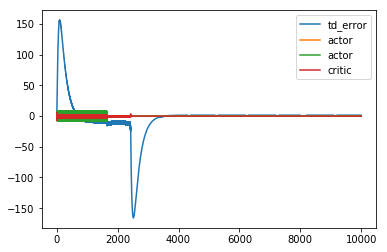

In [3]:
plt.plot(sim.data[err_probe], label='td_error')
plt.plot(sim.data[actor_probe], label='actor')
plt.plot(sim.data[critic_probe], label='critic')
# plt.plot(sim.data[place_probe], label='place')
plt.legend()

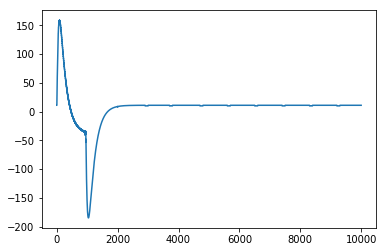

In [50]:
plt.plot(master.td_error_history)

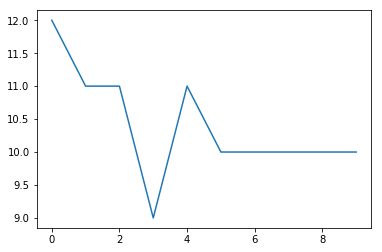

In [51]:
plt.plot(master.reward_history)

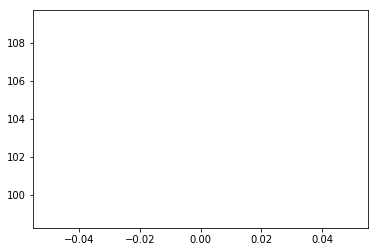

In [52]:
plt.plot(np.convolve(master.reward_history, np.ones(10), 'valid'))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

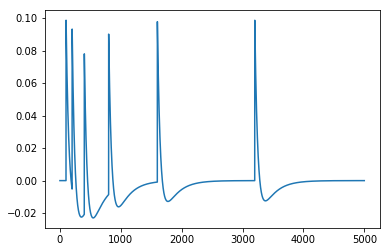

In [56]:
xs = []
def yolo(t, x):
    xs.append(x)

model = nengo.Network()
with model:
    nd_input = nengo.Node(lambda t: 1 if t % 0.1 == 0 else 0 ,size_out=1)
    td_error_node = nengo.Node(yolo, size_in=1)
#     nengo.Connection(critic.neurons, td_error_node, synapse=None)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(nd_input,
                     td_error_node,
                     synapse=tau_k,
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(nd_input,
                     td_error_node,
                     synapse=v_k,
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    
with nengo.Simulator(model) as sim:
    sim.run(5)
    
plt.plot(xs)

In [53]:
gym.make('Pendulum-v0').action_space

/Users/nolandey/anaconda/envs/tensorflow3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Box(1,)

In [62]:
n_actor = 180
lamb = 0.5
model = nengo.Network()
a = np.zeros((n_actor,1))
F_max = 2
actor_neurons = []
for k in range(n_actor):
    a[k] = 2*F_max*k / n_actor - F_max
    with model:
        neuron = nengo.Ensemble(1,1)
    actor_neurons.append(neuron)

for k in range(n_actor):
    for k_p in range(n_actor):
        if k == k_p: continue
        lateral_weight = np.exp(-((k - k_p)/lamb)**2)
        if lateral_weight == 0: continue
        print(lateral_weight)
        with model:
            nengo.Connection(actor_neurons[k].neurons,
                             actor_neurons[k_p].neurons,
                             transform=[lateral_weight])
    

0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.3195228302435696e-16
1.1253517471925912e-07


3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294

7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7

7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e

2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251


6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.12535174

7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e

1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-294
7.020667798504735e-251
6.3309773362105915e-211
1.9151695967140057e-174
1.9435148500492928e-141
6.616261056709485e-112
7.555819019711961e-86
2.8946403116483003e-63
3.720075976020836e-44
1.603810890548638e-28
2.3195228302435696e-16
1.1253517471925912e-07
0.01831563888873418
0.01831563888873418
1.1253517471925912e-07
2.3195228302435696e-16
1.603810890548638e-28
3.720075976020836e-44
2.8946403116483003e-63
7.555819019711961e-86
6.616261056709485e-112
1.9435148500492928e-141
1.9151695967140057e-174
6.3309773362105915e-211
7.020667798504735e-251
2.6117417612840555e-294
2.6117417612840555e-2

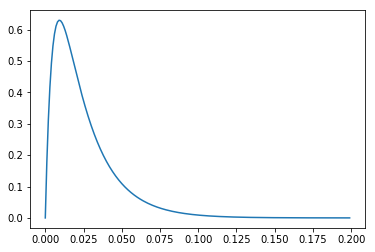

In [37]:
def k(t, v_k=50e-3, tau_k=200e-3):
    return ( np.exp(-t/tau_k) - np.exp(-t/v_k)) / (tau_k-v_k)
ts = np.arange(0,1,1e-3)
# plt.plot(ts, k(ts))

def k_dot(t, v_k=50e-3, tau_k=200e-3):
    return ( -np.exp(-t/tau_k)/tau_k + np.exp(-t/v_k)/v_k) / (tau_k-v_k)
# plt.plot(ts, k_dot(ts))

def epsp(s, eps_zero=20e-3, tau_m=20e-3, tau_s=5e-3):
    return (eps_zero/(tau_m - tau_s))*(np.exp(-s/tau_m)-np.exp(-s/tau_s))*np.heaviside(s, 1)
plt.plot(ts, epsp(ts))

# plt.plot(ts, k_dot(ts) - k(ts)/1)


In [36]:
model = nengo.Network()
with model:
    a = nengo.Ensemble(n_neurons=100, dimensions=1)
    b = nengo.Ensemble(n_neurons=50, dimensions=1)
    
w = 2*np.random.randn(b.n_neurons, a.n_neurons)/b.n_neurons
def my_rule(t, x):
    global w
    output = np.dot(w, x)*0.001
    w += np.random.randn(*w.shape)*0.01   # learning rule
    return output

with model:
    learner = nengo.Node(my_rule, size_in=a.n_neurons,
                         size_out=b.n_neurons)

    nengo.Connection(a.neurons, learner, synapse=None)
    nengo.Connection(learner, b.neurons, synapse=0.05)
    
with nengo.Simulator(model) as sim:
    sim.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

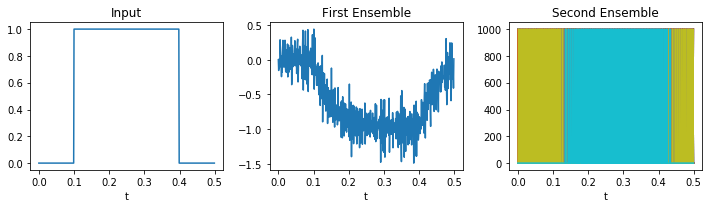

In [4]:
model = nengo.Network()
with model:
    nd_input = nengo.Node(lambda t: 1 if 0.1 < t < 0.4 else 0)
    ens1 = nengo.Ensemble(100,1)
    nengo.Connection(nd_input, ens1, synapse=0.05, transform=-1)
#     nengo.Connection(nd_input, ens1, synapse=0.05, transform=1)
    p0 = nengo.Probe(nd_input)
    p1 = nengo.Probe(ens1)
    p2 = nengo.Probe(ens1.neurons, attr='spikes')
    
dt = 1e-3
T = 0.5
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)

ts = np.arange(0,T,dt)
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(ts, sim.data[p0])
ax[0].set_xlabel('t')
ax[0].set_title('Input')
ax[1].plot(ts, sim.data[p1])
ax[1].set_xlabel('t')
ax[1].set_title('First Ensemble')
ax[2].plot(ts, sim.data[p2][:])
ax[2].set_xlabel('t')
ax[2].set_title('Second Ensemble')

plt.tight_layout()

In [8]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(2):
    observation = env.reset()
    print(observation)
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print(observation, reward, done, info)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[ 0.00995104 -0.02394673  0.03163717 -0.01828863]
[ 0.00947211 -0.21950777  0.0312714   0.28420592] 1.0 False {}
[ 0.00508195 -0.02484547  0.03695552  0.00154751] 1.0 False {}
[ 0.00458504 -0.22047739  0.03698647  0.30565749] 1.0 False {}
[ 0.0001755  -0.02590149  0.04309962  0.0248648 ] 1.0 False {}
[-0.00034253 -0.22161418  0.04359691  0.33082857] 1.0 False {}
[-0.00477482 -0.02713906  0.05021348  0.0522065 ] 1.0 False {}
[-0.0053176  -0.2229437   0.05125761  0.36029984] 1.0 False {}
[-0.00977647 -0.02858642  0.05846361  0.08420995] 1.0 False {}
[-0.0103482   0.16565087  0.06014781 -0.18946969] 1.0 False {}
[-0.00703518 -0.0302777   0.05635842  0.12156451] 1.0 False {}
[-0.00764074 -0.22615992  0.05878971  0.43148193] 1.0 False {}
[-0.01216394 -0.03191755  0.06741934  0.15789596] 1.0 False {}
[-0.01280229 -0.22793673  0.07057726  0.47106302] 1.0 False {}
[-0.01736102 -0.03387895  0.07999852  0.20143352] 1.0 False {}
[-0.0180386  -0.23004848  0.08402719  0.51824122] 1.0 False {}
[-0.0